# From `zipline` to `pyfolio`

[Pyfolio](http://quantopian.github.io/pyfolio/) facilitates the analysis of portfolio performance and risk in-sample and out-of-sample using many standard metrics. It produces tear sheets covering the analysis of returns, positions, and transactions, as well as event risk during periods of market stress using several built-in scenarios, and also includes Bayesian out-of-sample performance analysis.

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* State-of-the-art portfolio and risk analytics
* Various models for transaction costs and slippage.
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian

Run this note the following from the command line to create a `conda` environment with `zipline` and `pyfolio`: 
```
conda env create -f environment.yml
```
This assumes you have miniconda3 installed.

## Imports & Settings

In [1]:
from pathlib import Path
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_fama_french,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_rolling_volatility,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges
# from pyfolio.tears import create_returns_tear_sheet

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Converting data from zipline to pyfolio

In [43]:
with pd.HDFStore('../01_trade_simulation_pf_management_zipline/backtests.h5') as store:
    backtest = store['backtest/equal_weight']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2013-01-02 to 2016-12-30
Data columns (total 39 columns):
algo_volatility            1007 non-null float64
algorithm_period_return    1008 non-null float64
alpha                      1007 non-null float64
benchmark_period_return    1008 non-null float64
benchmark_volatility       1007 non-null float64
beta                       1007 non-null float64
capital_used               1008 non-null float64
ending_cash                1008 non-null float64
ending_exposure            1008 non-null float64
ending_value               1008 non-null float64
excess_return              1008 non-null float64
factor_data                1008 non-null object
gross_leverage             1008 non-null float64
long_exposure              1008 non-null float64
long_value                 1008 non-null float64
longs_count                1008 non-null int64
max_drawdown               1008 non-null float64
max_leverage               1008 non-null floa

`pyfolio` relies on portfolio returns and position data, and can also take into account the transaction costs and slippage losses of trading activity. The metrics are computed using the empyrical library that can also be used on a standalone basis. The performance DataFrame produced by the zipline backtesting engine can be translated into the requisite pyfolio input.

In [44]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [45]:
returns.head().append(returns.tail())

2013-01-02 00:00:00+00:00    0.000000
2013-01-03 00:00:00+00:00   -0.000010
2013-01-04 00:00:00+00:00    0.005426
2013-01-07 00:00:00+00:00   -0.001473
2013-01-08 00:00:00+00:00    0.003294
2016-12-23 00:00:00+00:00    0.003175
2016-12-27 00:00:00+00:00   -0.001189
2016-12-28 00:00:00+00:00   -0.002018
2016-12-29 00:00:00+00:00    0.000493
2016-12-30 00:00:00+00:00   -0.001231
Name: returns, dtype: float64

In [46]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2013-01-03 to 2016-12-30
Columns: 1375 entries, Equity(0 [A]) to cash
dtypes: float64(1375)
memory usage: 10.6 MB


In [47]:
positions.columns = [c for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2013-01-03 to 2016-12-30
Columns: 1375 entries, Equity(0 [A]) to cash
dtypes: float64(1375)
memory usage: 10.6 MB


In [48]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [49]:
transactions.head().append(transactions.tail())

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2013-01-03 21:00:00+00:00,2049,None,2013-01-03 21:00:00+00:00,d60e80c1bfe44165ab094507677c0053,31.640002,Equity(2304 [PRXL]),PRXL,-64830.364051
2013-01-03 21:00:00+00:00,4368,None,2013-01-03 21:00:00+00:00,8d70ed9e22614b33873aeaf84fc640a8,46.970002,Equity(833 [DKS]),DKS,-205164.970798
2013-01-03 21:00:00+00:00,6146,None,2013-01-03 21:00:00+00:00,c3589240ca9e492ba5dcc1724946b932,32.560000,Equity(1859 [MO]),MO,-200113.760598
2013-01-03 21:00:00+00:00,6329,None,2013-01-03 21:00:00+00:00,317df48d3c724ef2b990768d25f8b521,32.500001,Equity(1093 [FL]),FL,-205692.508360
2013-01-03 21:00:00+00:00,1777,None,2013-01-03 21:00:00+00:00,96d816c8fae64bf39ec70fe4a797a139,25.770002,Equity(1415 [HTS]),HTS,-45793.292861
2016-12-30 21:00:00+00:00,-692,None,2016-12-30 21:00:00+00:00,4add5f08a20644abb40fe839a2524d2c,70.649996,Equity(2210 [PFPT]),PFPT,48889.796951
2016-12-30 21:00:00+00:00,-703,None,2016-12-30 21:00:00+00:00,29a40650368c42a2b41c6916c9113d68,94.239994,Equity(2486 [SAFM]),SAFM,66250.715864
2016-12-30 21:00:00+00:00,-1350,None,2016-12-30 21:00:00+00:00,b6e668dac82840bd96b157a921682c07,25.519998,Equity(1463 [IGT]),IGT,34451.997847
2016-12-30 21:00:00+00:00,-3389,None,2016-12-30 21:00:00+00:00,9bf00eb58ca646fd9ebe8eec5c8293f9,17.979999,Equity(2376 [RDN]),RDN,60934.216193
2016-12-30 21:00:00+00:00,-2511,None,2016-12-30 21:00:00+00:00,d1f74eecf0634c92957867c162480103,12.790000,Equity(1500 [INVN]),INVN,32115.689466


In [50]:
HDF_PATH = Path('..', '..', 'data', 'assets.h5')

### Sector Map

In [51]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [52]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/prices'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

date
2016-12-23 00:00:00+00:00    0.001252
2016-12-27 00:00:00+00:00    0.002248
2016-12-28 00:00:00+00:00   -0.008357
2016-12-29 00:00:00+00:00   -0.000293
2016-12-30 00:00:00+00:00   -0.004637
Name: S&P500, dtype: float64

In [53]:
perf_stats(returns=returns, factor_returns=benchmark_rets, positions=positions, transactions=transactions)

Annual return          0.027790
Cumulative returns     0.115878
Annual volatility      0.084798
Sharpe ratio           0.365568
Calmar ratio           0.212380
Stability              0.262608
Max drawdown          -0.130848
Omega ratio            1.071802
Sortino ratio          0.536641
Skew                   0.333962
Kurtosis               7.200205
Tail ratio             1.041581
Daily value at risk   -0.010561
Gross leverage         0.691548
Daily turnover         0.080677
Alpha                  0.000956
Beta                   0.248189
dtype: float64

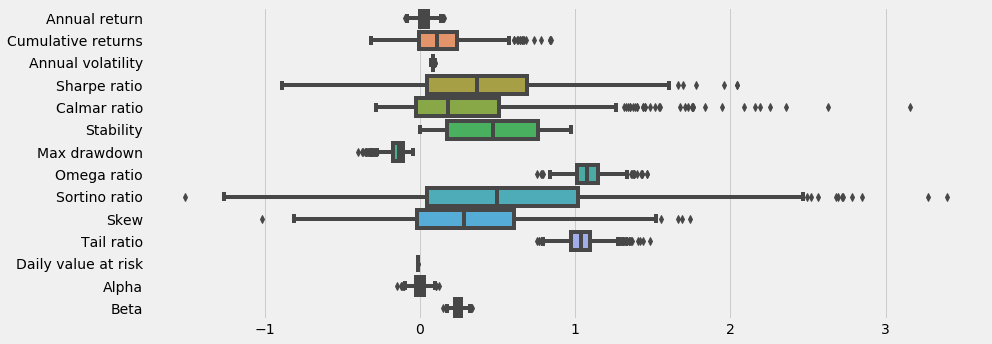

In [64]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_perf_stats(returns=returns, factor_returns=benchmark_rets, ax=ax)
fig.tight_layout()
fig.savefig('../figures/perf_stats', dpi=300);

## Returns Analysis

Testing a trading strategy involves backtesting against historical data to fine-tune alpha factor parameters, as well as forward-testing against new market data to validate that the strategy performs well out of sample or if the parameters are too closely tailored to specific historical circumstances.

Pyfolio allows for the designation of an out-of-sample period to simulate walk-forward testing. There are numerous aspects to take into account when testing a strategy to obtain statistically reliable results, which we will address here. 

In [55]:
oos_date = '2016-01-01'

In [56]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

In-sample months: 36
Out-of-sample months: 12


,All,In-sample,Out-of-sample
Annual return,2.8%,2.1%,4.7%
Cumulative returns,11.6%,6.6%,4.7%
Annual volatility,8.5%,8.8%,7.6%
Sharpe ratio,0.37,0.29,0.64
Calmar ratio,0.21,0.16,0.57
Stability,0.26,0.01,0.67
Max drawdown,-13.1%,-13.1%,-8.3%
Omega ratio,1.07,1.06,1.11
Sortino ratio,0.54,0.42,0.96
Skew,0.33,0.35,0.25


### Rolling Returns OOS

The `plot_rolling_returns` function displays cumulative in and out-of-sample returns against a user-defined benchmark (we are using the S&P 500):


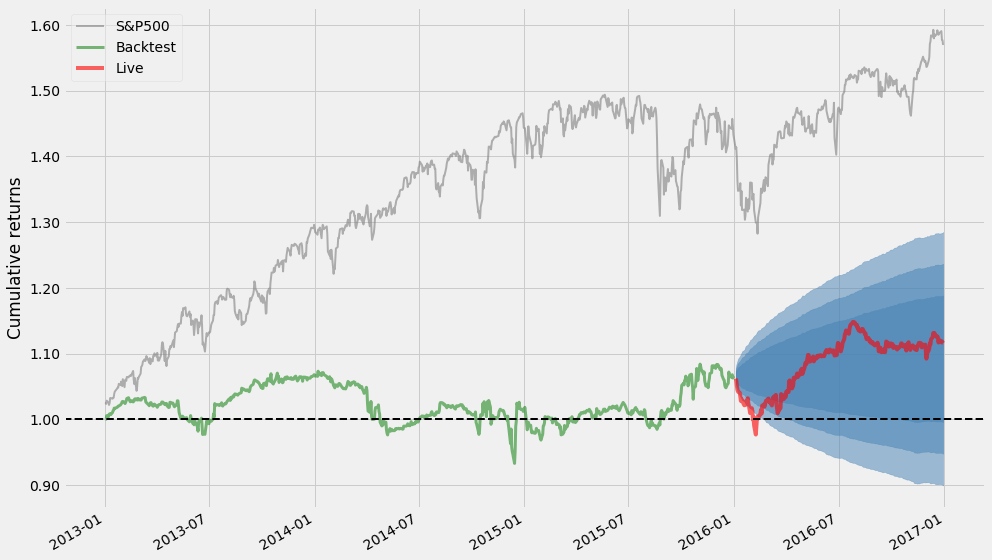

In [63]:
plot_rolling_returns(returns=returns, 
                     factor_returns=benchmark_rets, 
                     live_start_date=oos_date, 
                     cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)
plt.tight_layout()
plt.savefig('../figures/rolling_returns', dpi=300)

The plot includes a cone that shows expanding confidence intervals to indicate when out-of-sample returns appear unlikely given random-walk assumptions. Here, our strategy did not perform well against the benchmark during the simulated 2017 out-of-sample period

## Summary Performance Statistics

pyfolio offers several analytic functions and plots. The perf_stats summary displays the annual and cumulative returns, volatility, skew, and kurtosis of returns and the SR. The following additional metrics (which can also be calculated individually) are most important:
- Max drawdown: Highest percentage loss from the previous peak
- Calmar ratio: Annual portfolio return relative to maximal drawdown
- Omega ratio: The probability-weighted ratio of gains versus losses for a return target, zero per default
- Sortino ratio: Excess return relative to downside standard deviation
- Tail ratio: Size of the right tail (gains, the absolute value of the 95th percentile) relative to the size of the left tail (losses, abs. value of the 5th percentile) 
- Daily value at risk (VaR): Loss corresponding to a return two standard deviations below the daily mean
- Alpha: Portfolio return unexplained by the benchmark return
- Beta: Exposure to the benchmark


### Rolling Sharpe

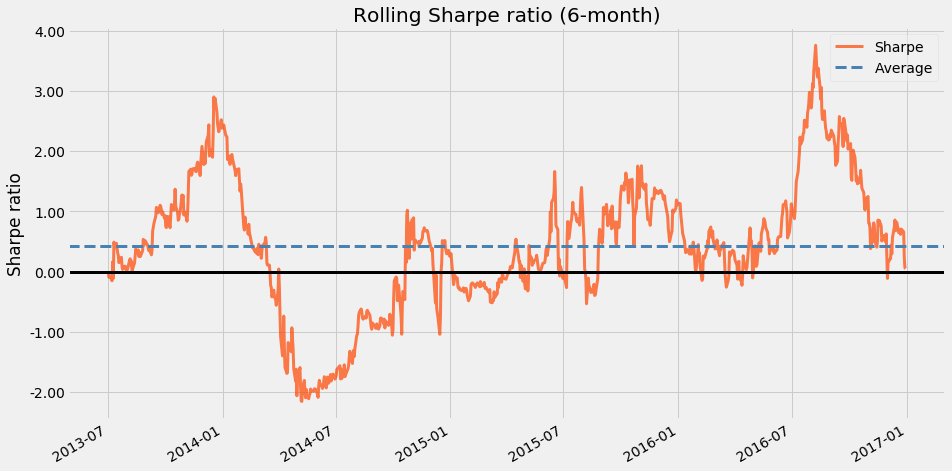

In [58]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8);

### Rolling Beta

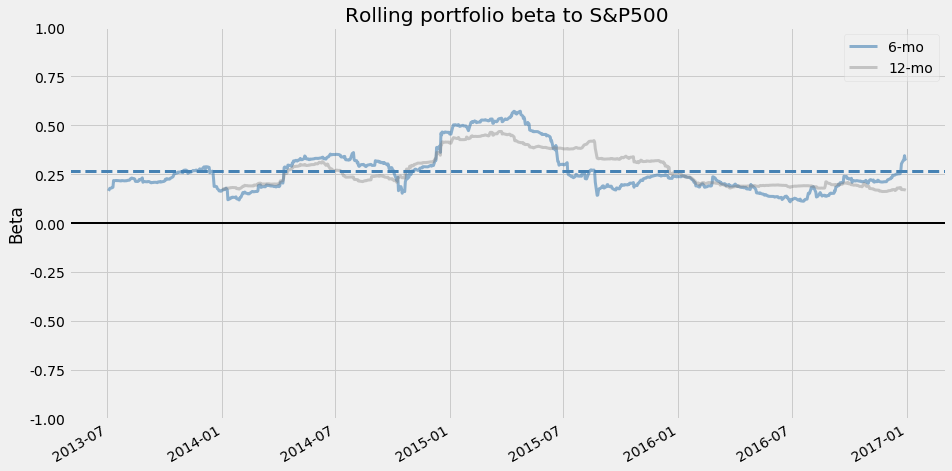

In [59]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 8);

## Drawdown Periods

The plot_drawdown_periods(returns) function plots the principal drawdown periods for the portfolio, and several other plotting functions show the rolling SR and rolling factor exposures to the market beta or the Fama French size, growth, and momentum factors:

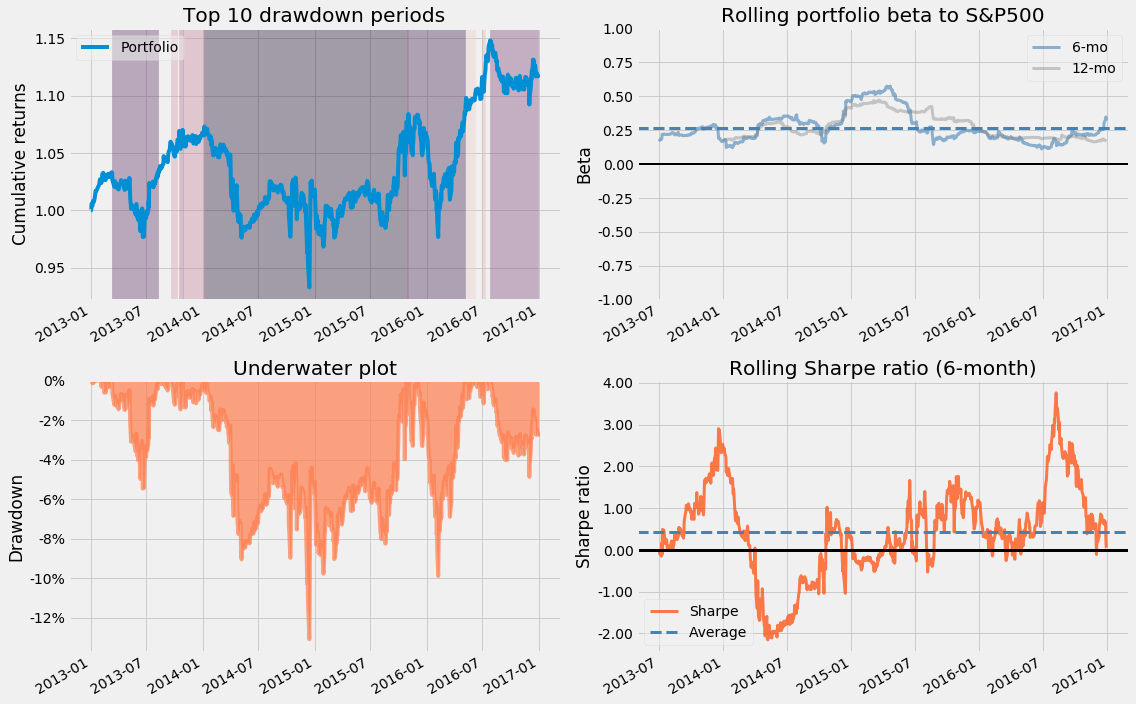

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_drawdown_underwater(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
plt.tight_layout()
fig.savefig('../figures/drawdown', dpi=300);

This plot, which highlights a subset of the visualization contained in the various tear sheets, illustrates how pyfolio allows us to drill down into the performance characteristics and exposure to fundamental drivers of risk and returns.

## Modeling Event Risk

Pyfolio also includes timelines for various events that you can use to compare the performance of a portfolio to a benchmark during this period, for example, during the fall 2015 selloff following the Brexit vote.

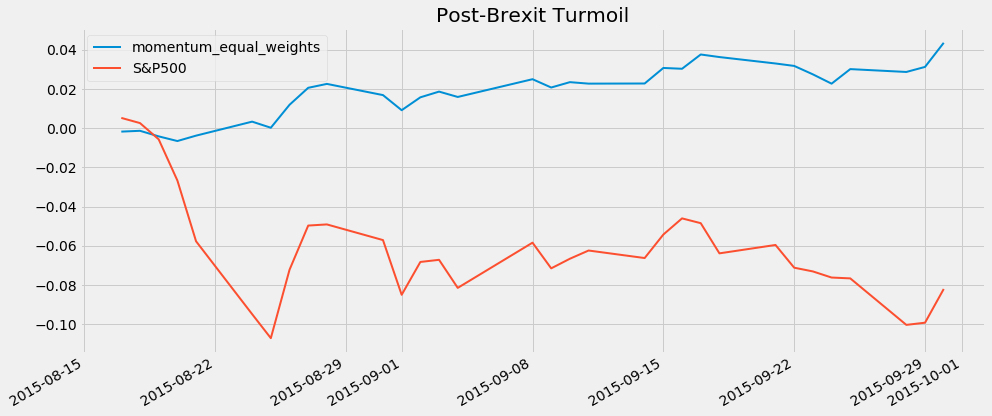

In [67]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('momentum_equal_weights').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
plt.tight_layout()
plt.savefig('../figures/brexit', dpi=300);